In [10]:
import yt
from yt_experiments.tiled_grid import YTTiledArbitraryGrid, YTPyramid
import matplotlib.pyplot as plt
import numpy as np
import zarr
import os
import shutil

In [4]:
ds = yt.load("Lightcone/RD0036/RD0036")

yt : [INFO     ] 2024-08-28 11:09:04,467 Parameters: current_time              = 646.75066015177
yt : [INFO     ] 2024-08-28 11:09:04,467 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2024-08-28 11:09:04,467 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-08-28 11:09:04,468 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-08-28 11:09:04,468 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-08-28 11:09:04,468 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2024-08-28 11:09:04,469 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2024-08-28 11:09:04,469 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2024-08-28 11:09:04,469 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-08-28 11:09:04,469 Parameters: hubble_constant           = 0.7


Parsing Hierarchy : 100%|████████████████████████████████████████████████████| 392865/392865 [00:13<00:00, 28150.35it/s]
yt : [INFO     ] 2024-08-28 11:09:40,403 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2024-08-28 11:09:41,997 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-08-28 11:09:41,997 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-08-28 11:09:41,998 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-08-28 11:09:41,999 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-08-28 11:09:42,002 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



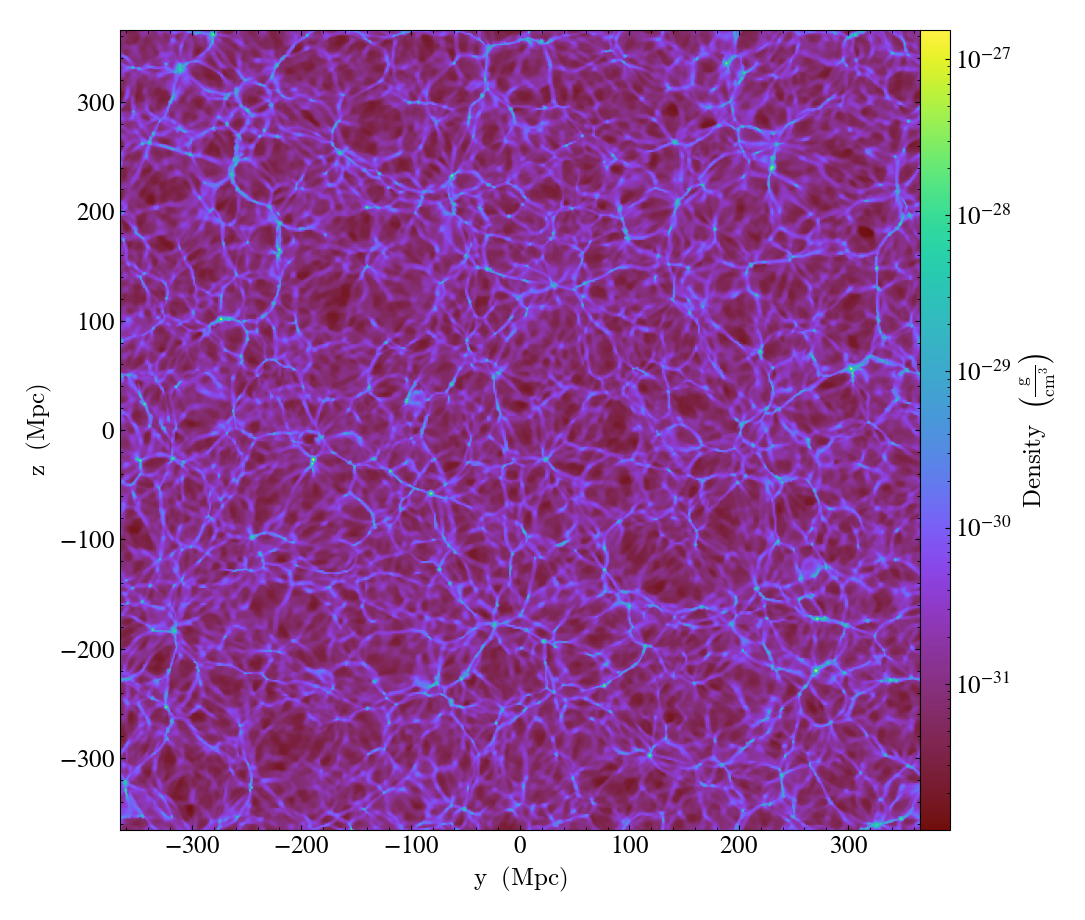

In [5]:
yt.SlicePlot(ds, "x", ("gas", "density"))

yt : [INFO     ] 2024-08-28 11:09:50,185 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-08-28 11:09:50,186 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-08-28 11:09:50,187 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-08-28 11:09:50,187 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-08-28 11:09:50,188 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



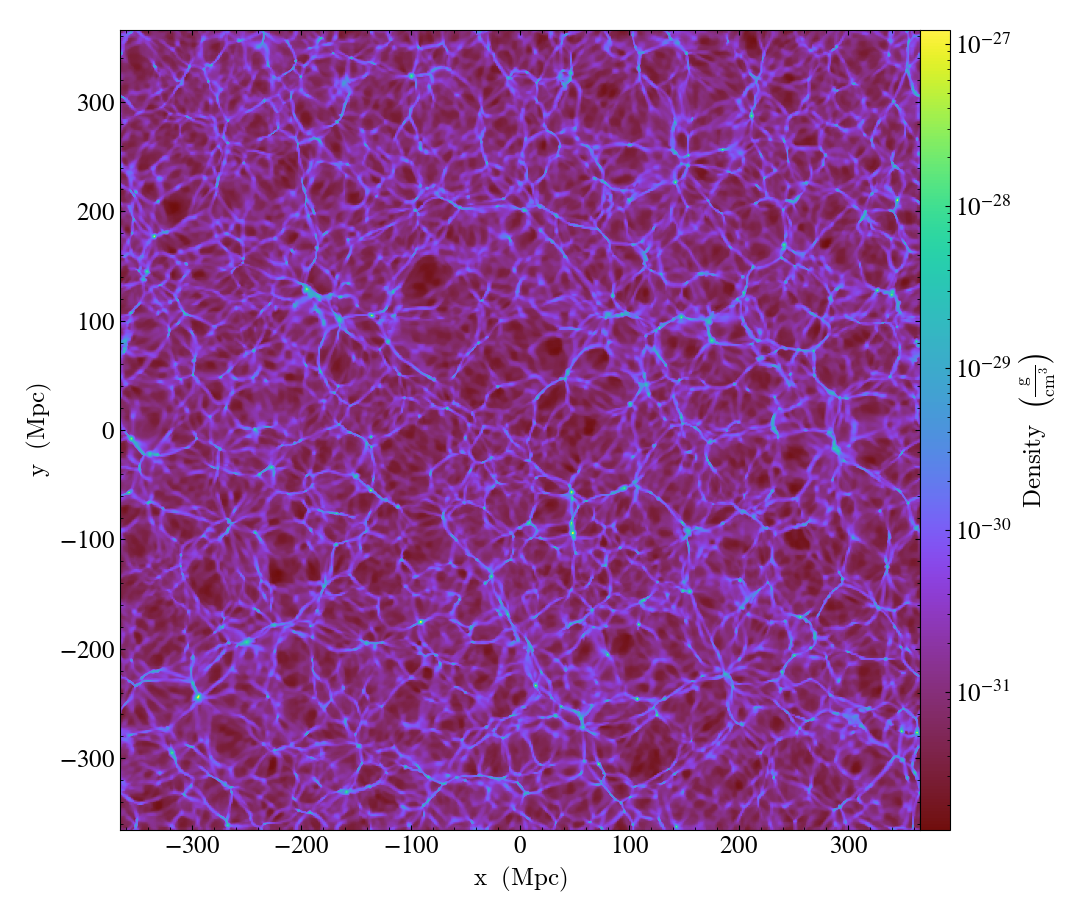

In [6]:
yt.SlicePlot(ds, "z", ("gas", "density"))

In [11]:
def initialize_store(store_name: str, rm_existing: bool = True):
    """
    initialize a top level on-disk zarr store, optionally
    deleting existing store at the same location. If you
    have the yt test_data_dir set, will initialize at
    test_data_dir / store_name, otherwise will initialize in the
    current directory
    """
    store_dir = yt.config.ytcfg.get("yt", "test_data_dir")
    if store_dir == yt.config.ytcfg_defaults["yt"]["test_data_dir"]:
        store_dir = os.curdir
    store_top = os.path.join(store_dir, store_name)
    if os.path.exists(store_top) and rm_existing:
        shutil.rmtree(store_top)
    zarr_store = zarr.group(store_top)
    return zarr_store

## 2d-optimized image pyramid

In [27]:
n_levels = 11
level_dims = []
level_chunks = []
for lev in range(n_levels, 3, -1):
    res = (int(2**lev),) * 3
    level_dims.append(res)
    level_chunks.append((1, res[1], res[2]))

im_pyr = YTPyramid(
    ds.domain_left_edge, ds.domain_right_edge, level_dims, level_chunks, ds=ds
)

Decomposing [2048 2048 2048] into 2048 chunks for level 0
Decomposing [1024 1024 1024] into 1024 chunks for level 1
Decomposing [512 512 512] into 512 chunks for level 2
Decomposing [256 256 256] into 256 chunks for level 3
Decomposing [128 128 128] into 128 chunks for level 4
Decomposing [64 64 64] into 64 chunks for level 5
Decomposing [32 32 32] into 32 chunks for level 6
Decomposing [16 16 16] into 16 chunks for level 7


In [28]:
# zarr_store = initialize_store("lightcone_pyramid.zarr")

In [29]:
im_pyr.to_zarr(
    ("gas", "density"),
    zarr_store,
    zarr_name="gas_density",
    ops=[
        np.log10,
    ],
    dtype=np.float32,
)

writing level 0
writing level 1
writing level 2
writing level 3
writing level 4
writing level 5
writing level 6
writing level 7


In [30]:
import napari

v = napari.Viewer()

In [32]:
multiscale_img = [vals for _, vals in zarr_store["gas_density"].arrays()]
multiscale_img

[<zarr.core.Array '/gas_density/0' (2048, 2048, 2048) float32>,
 <zarr.core.Array '/gas_density/1' (1024, 1024, 1024) float32>,
 <zarr.core.Array '/gas_density/2' (512, 512, 512) float32>,
 <zarr.core.Array '/gas_density/3' (256, 256, 256) float32>,
 <zarr.core.Array '/gas_density/4' (128, 128, 128) float32>,
 <zarr.core.Array '/gas_density/5' (64, 64, 64) float32>,
 <zarr.core.Array '/gas_density/6' (32, 32, 32) float32>,
 <zarr.core.Array '/gas_density/7' (16, 16, 16) float32>]

In [34]:
v.add_image(multiscale_img, multiscale=True)

<Image layer 'multiscale_img' at 0x500ba7bb0>